# getting average response within ROI across multiple traces: step-by-step


In [1]:
import lib.fileIngest as fileIngest

xsgs = []
# dPaths = ["../data/AA0308","../data/AA0310","../data/AA0315"]
dPaths = ["../data/AA0308"]


df = fileIngest.qcamPath2table(dPaths,format='PAC')
df

,qcam,dir,xsg,pulse,dB
0,../data/AA0308/AA0308AAAA0002.qcamraw,../data/AA0308,../data/AA0308/AA0308AAAA0002.xsg,11892Hz_70dB_TestTone_400msPulse_at_3s_10msRam...,70
1,../data/AA0308/AA0308AAAA0003.qcamraw,../data/AA0308,../data/AA0308/AA0308AAAA0003.xsg,5612Hz_60dB_TestTone_400msPulse_at_3s_10msRamp...,60
2,../data/AA0308/AA0308AAAA0008.qcamraw,../data/AA0308,../data/AA0308/AA0308AAAA0008.xsg,5000Hz_60dB_TestTone_400msPulse_at_3s_10msRamp...,60
3,../data/AA0308/AA0308AAAA0011.qcamraw,../data/AA0308,../data/AA0308/AA0308AAAA0011.xsg,12599Hz_70dB_TestTone_400msPulse_at_3s_10msRam...,70
4,../data/AA0308/AA0308AAAA0001.qcamraw,../data/AA0308,../data/AA0308/AA0308AAAA0001.xsg,11892Hz_70dB_TestTone_400msPulse_at_3s_10msRam...,70
5,../data/AA0308/AA0308AAAA0010.qcamraw,../data/AA0308,../data/AA0308/AA0308AAAA0010.xsg,5453Hz_60dB_TestTone_400msPulse_at_3s_10msRamp...,60
6,../data/AA0308/AA0308AAAA0009.qcamraw,../data/AA0308,../data/AA0308/AA0308AAAA0009.xsg,5297Hz_60dB_TestTone_400msPulse_at_3s_10msRamp...,60
7,../data/AA0308/AA0308AAAA0005.qcamraw,../data/AA0308,../data/AA0308/AA0308AAAA0005.xsg,5000Hz_60dB_TestTone_400msPulse_at_3s_10msRamp...,60
8,../data/AA0308/AA0308AAAA0004.qcamraw,../data/AA0308,../data/AA0308/AA0308AAAA0004.xsg,5453Hz_60dB_TestTone_400msPulse_at_3s_10msRamp...,60
9,../data/AA0308/AA0308AAAA0006.qcamraw,../data/AA0308,../data/AA0308/AA0308AAAA0006.xsg,11892Hz_70dB_TestTone_400msPulse_at_3s_10msRam...,70


In [2]:
# 1. get list of qcams
# 2. get average image 
# 3. calc spatial dff response
# 4. get mask 
# 5. apply mask over each file

In [3]:
dB = 60

# 1.
qcams = df[df['dB']==dB]['qcam'].tolist()
qcams

['../data/AA0308/AA0308AAAA0003.qcamraw',
 '../data/AA0308/AA0308AAAA0008.qcamraw',
 '../data/AA0308/AA0308AAAA0010.qcamraw',
 '../data/AA0308/AA0308AAAA0009.qcamraw',
 '../data/AA0308/AA0308AAAA0005.qcamraw',
 '../data/AA0308/AA0308AAAA0004.qcamraw']

In [4]:
import numpy as np

# 2.
imgs,headers = fileIngest.qcams2imgs(qcams)
print(imgs[0].shape)
print(len(imgs))
avgImgSeries = np.array(imgs).mean(axis=(0))
np.array(avgImgSeries).shape

(150, 200, 200)
6


(150, 200, 200)

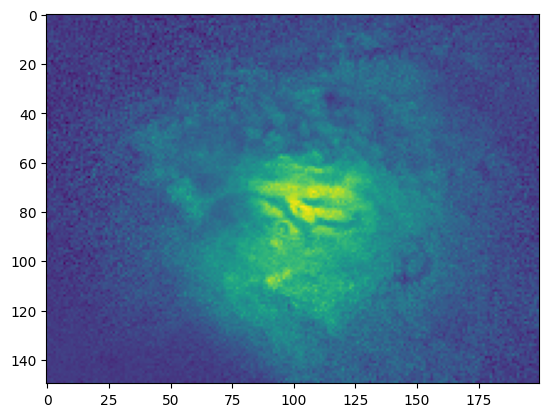

In [6]:
import lib.imgProcess as imgProcess
import matplotlib.pyplot as plt

# 3.
spatialDFF = imgProcess.calcSpatialDFFresp(avgImgSeries)
plt.imshow(spatialDFF)

In [7]:
# long mouse click to start drawing polygon, single click to add vertices, long mouse lick to make last edge.

# 4. get mask
ui, mask_output = imgProcess.getROImaskUI(spatialDFF)
# Show the UI
ui

BokehModel(combine_events=True, render_bundle={'docs_json': {'f1c83810-92f7-4824-9234-b906981e2d31': {'version…

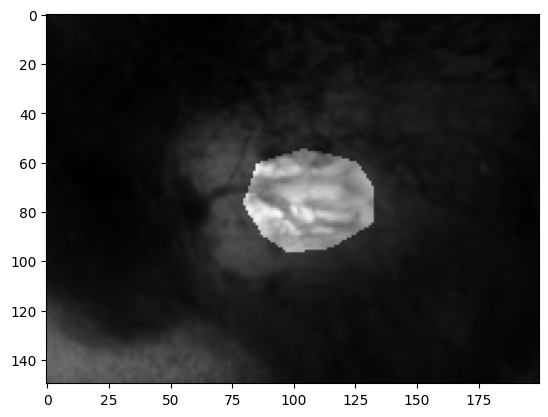

In [8]:
plt.imshow(avgImgSeries.mean(axis=2)*(mask_output['mask']+.5),cmap='gray')

In [9]:
print(np.array(avgImgSeries)[mask_output['mask']==1,:].shape)
print(np.array(imgs)[:,mask_output['mask']==1,:].shape)

(1701, 200)
(6, 1701, 200)


In [10]:
# save mask
import joblib
import os

joblib.dump(mask_output['mask'],os.path.join(df.dir.unique()[0],f'{dB}dB_ROImask.joblib'))

['../data/AA0308/60dB_ROImask.joblib']

Text(0.5, 1.0, 'roi')

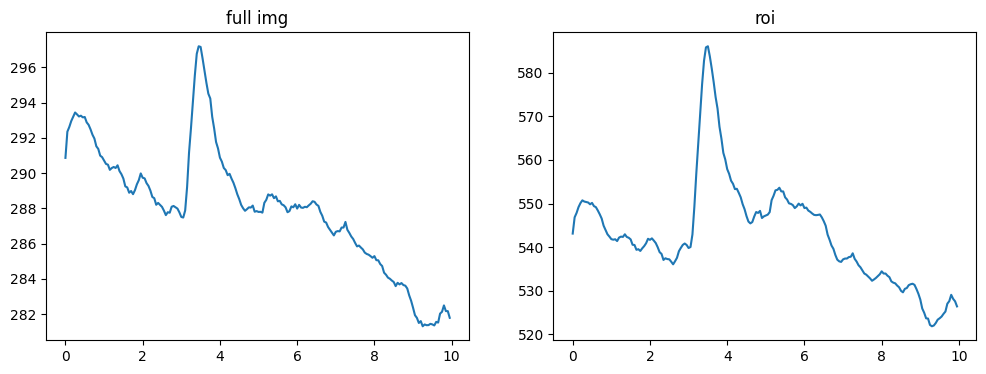

In [15]:
# 5. apply mask
import lib.signalProcess as signalProcess

# if want mask for each trace:
# np.array(imgs)[:,mask_output['mask']==1,:]

t = signalProcess.getTimeVec(avgImgSeries.shape[-1])
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(t,avgImgSeries.mean(axis=(0,1)))
ax[0].set_title('full img')
ax[1].plot(t,avgImgSeries[mask_output['mask']==1,:].mean(axis=0))
ax[1].set_title('roi')


Text(0.5, 1.0, 'roi')

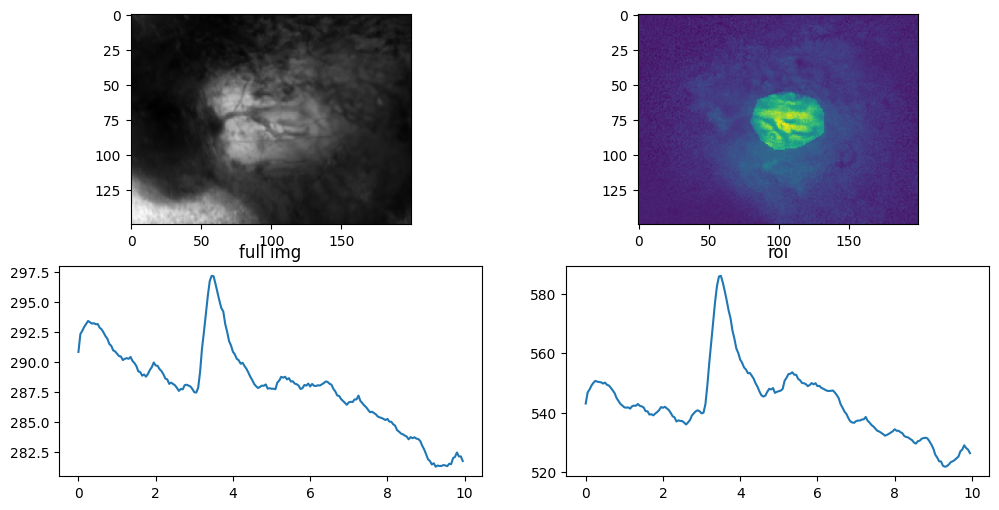

In [16]:
fig,ax = plt.subplots(2,2,figsize=(12,6))
ax[0,0].imshow(avgImgSeries.mean(axis=2),cmap='gray')
ax[0,1].imshow(spatialDFF*(mask_output['mask']+.8),cmap='viridis')
ax[1,0].plot(t,avgImgSeries.mean(axis=(0,1)))
ax[1,0].set_title('full img')
ax[1,1].plot(t,avgImgSeries[mask_output['mask']==1,:].mean(axis=0))
ax[1,1].set_title('roi')

# as function

In [1]:
import lib.fileIngest as fileIngest
import lib.imgProcess as imgProcess

xsgs = []
# dPaths = ["../data/AA0308","../data/AA0310","../data/AA0315"]
dPaths = ["../data/AA0308"]

df = fileIngest.qcamPath2table(dPaths,format='PAC')
df

,qcam,dir,xsg,pulse,dB
0,../data/AA0308/AA0308AAAA0004.qcamraw,../data/AA0308,../data/AA0308/AA0308AAAA0004.xsg,5453Hz_60dB_TestTone_400msPulse_at_3s_10msRamp...,60
1,../data/AA0308/AA0308AAAA0009.qcamraw,../data/AA0308,../data/AA0308/AA0308AAAA0009.xsg,5297Hz_60dB_TestTone_400msPulse_at_3s_10msRamp...,60
2,../data/AA0308/AA0308AAAA0005.qcamraw,../data/AA0308,../data/AA0308/AA0308AAAA0005.xsg,5000Hz_60dB_TestTone_400msPulse_at_3s_10msRamp...,60
3,../data/AA0308/AA0308AAAA0006.qcamraw,../data/AA0308,../data/AA0308/AA0308AAAA0006.xsg,11892Hz_70dB_TestTone_400msPulse_at_3s_10msRam...,70
4,../data/AA0308/AA0308AAAA0010.qcamraw,../data/AA0308,../data/AA0308/AA0308AAAA0010.xsg,5453Hz_60dB_TestTone_400msPulse_at_3s_10msRamp...,60
5,../data/AA0308/AA0308AAAA0002.qcamraw,../data/AA0308,../data/AA0308/AA0308AAAA0002.xsg,11892Hz_70dB_TestTone_400msPulse_at_3s_10msRam...,70
6,../data/AA0308/AA0308AAAA0011.qcamraw,../data/AA0308,../data/AA0308/AA0308AAAA0011.xsg,12599Hz_70dB_TestTone_400msPulse_at_3s_10msRam...,70
7,../data/AA0308/AA0308AAAA0008.qcamraw,../data/AA0308,../data/AA0308/AA0308AAAA0008.xsg,5000Hz_60dB_TestTone_400msPulse_at_3s_10msRamp...,60
8,../data/AA0308/AA0308AAAA0007.qcamraw,../data/AA0308,../data/AA0308/AA0308AAAA0007.xsg,11892Hz_70dB_TestTone_400msPulse_at_3s_10msRam...,70
9,../data/AA0308/AA0308AAAA0001.qcamraw,../data/AA0308,../data/AA0308/AA0308AAAA0001.xsg,11892Hz_70dB_TestTone_400msPulse_at_3s_10msRam...,70


In [2]:
dB = 70

# 1.
qcams = df[df['dB']==dB]['qcam'].tolist()
qcams

['../data/AA0308/AA0308AAAA0006.qcamraw',
 '../data/AA0308/AA0308AAAA0002.qcamraw',
 '../data/AA0308/AA0308AAAA0011.qcamraw',
 '../data/AA0308/AA0308AAAA0007.qcamraw',
 '../data/AA0308/AA0308AAAA0001.qcamraw']

In [3]:
# long mouse click to start drawing polygon, single click to add vertices, long mouse lick to make last edge.

ui,dmask,imgs,spatialDFF = imgProcess.qcams2roiTrace(qcams)
ui

BokehModel(combine_events=True, render_bundle={'docs_json': {'c749433f-41d0-4451-8954-59de4f30c2c8': {'version…

(5, 200)

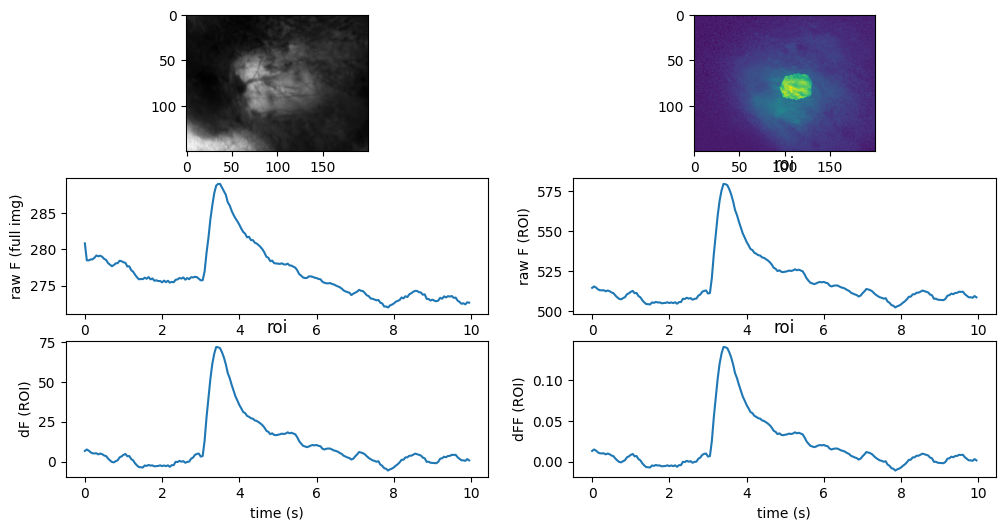

In [4]:
roiTrace = imgProcess.mask2trace(dmask['mask'], imgs, spatialDFF)
roiTrace.shape

(5, 200)


Text(0.5, 0, 'time (s)')

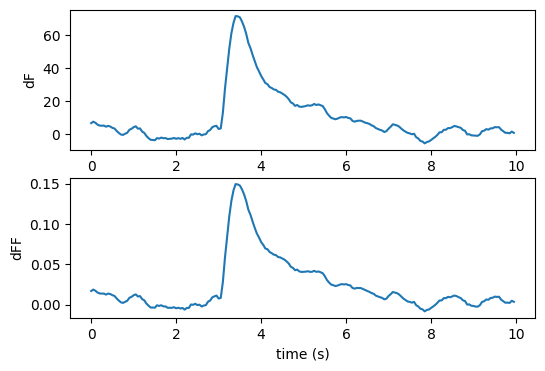

In [21]:
# manual dFF calculation:

from lib.signalProcess import dFFcalc, getTimeVec
import matplotlib.pyplot as plt

dFF,dF = dFFcalc(roiTrace)[:2]
t = getTimeVec(dFF.shape[-1])
print(dFF.shape)

fig,ax = plt.subplots(2,1,figsize=(6,4))
ax[0].plot(t,dF.mean(axis=0))
ax[0].set_ylabel('dF')
ax[1].plot(t,dFF.mean(axis=0))
ax[1].set_ylabel('dFF')
ax[1].set_xlabel('time (s)')